# Reducción y análisis de datos de observaciones de XMM Newton

---

A continuación se listan losp pasos a seguir para recalibrar, filtrar y obtener el espectro y curva de luz de una fuente puntual a partir de las observaciones "crudas" de XMM-Newton.

## Reprocesamiento

1. Apuntar la variable `SAS_ODF` a la carpeta donde se encuentran las observaciones, p. ej.:
   `export SAS_ODF=/home/shluna/Proyectos/RX/objetos/rtcru/observaciones/xmm/0831790801`
   Antes de continuar, se debe verificar que la variable `SAS_CCFPATH` esté definida en `.bashrc` apuntando a la carpeta donde se encuantran los archivos de calibración.
2. Luego, ejecutar la tareas `cifbuild`, la cual crea el archivo `cif.ccf`.
3. Apuntar la variable `SAS_CCF` a este último archivo:`export SAS_CCF=cif.ccf`.
4. Ejecutar la tarea `odfingest` para actualizar el archivo de resumen `*SUM.SAS`.
5. Apuntar la variable `SAS_ODF` al archivo de resumen actualizado: `export SAS_ODF=*SUM.SAS`.
6. Por último, ejecutar las tareas `emproc`y `epproc` para reprocesar las observaciones de los detectores EPIC-MOS y EPIC-pn, respectivamente.

## Filtrado de la lista de eventos

Antes de comenzar conviene hacer una copia de seguridad de las listas eventos originales detectados por cada cámara. Estos están guardado en los archivos que finalizan `*Evts.ds`:

- `cp 3522_0831790801_EPN_S003_ImagingEvts.ds PN.fits`
- `cp 3522_0831790801_EMOS1_S001_ImagingEvts.ds M1.fits`
- `cp 3522_0831790801_EMOS2_S002_ImagingEvts.ds M2.fits`

Ahora sí, se comienza con el filtrado:

1. Extraer una curva de luz de eventos singulares (con patrón “0”) a energías por encima de 10 keV para cada cámara (PN, MOS1, MOS2) para identificar los intervalos de alto background, usando la tarea `evselect` de SAS:

    - `evselect table=PN.fits withrateset=Y rateset=ratesPN.fits maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression='#XMMEA_EP && (PI>10000&&PI<12000) && (PATTERN==0)'`
    - `evselect table=M1.fits withrateset=Y rateset=ratesM1.fits maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression='#XMMEA_EM && (PI>10000) && (PATTERN==0)'`
    - `evselect table=M2.fits withrateset=Y rateset=ratesM2.fits maketimecolumn=Y timebinsize=100 makeratecolumn=Y expression='#XMMEA_EM && (PI>10000) && (PATTERN==0)'`

La curva de luz resultante puede ser visualizada usando dsplot: `dsplot table=rateEPIC.fits x=TIME y=RATE`

2. Usando la tarea `tabgtigen` se determinan los intervalos de tiempo en los que la curva de luz es baja y constante eligiendo un límite o *threshold* (en cuentas por segundo) para crear el archivo GTI, `EPICgti.fits`:
   
   - `tabgtigen table=ratesPN.fits expression='RATE<=0.4' gtiset=PNgti.fits`
   - `tabgtigen table=ratesM1.fits expression='RATE<=0.35' gtiset=M1gti.fits`
   - `tabgtigen table=ratesM2.fits expression='RATE<=0.35' gtiset=M2gti.fits`

3. Por último, usamos nuevamente `evselect` para generar la lista de eventos filtrada, `EPICclean.fits`:

   - `evselect table=PN.fits withfilteredset=Y filteredset=PNclean.fits destruct=Y keepfilteroutput=T expression='#XMMEA_EP && gti(PNgti.fits,TIME) && (PI>150)'`
   - `evselect table=M1.fits withfilteredset=Y filteredset=M1clean.fits destruct=Y keepfilteroutput=T expression='#XMMEA_EM && gti(M1gti.fits,TIME) && (PI>150)'`
   - `evselect table=M2.fits withfilteredset=Y filteredset=M2clean.fits destruct=Y keepfilteroutput=T expression='#XMMEA_EM && gti(M2gti.fits,TIME) && (PI>150)'`

## Obtención de la curva de luz

1. En primer lugar, se deben inicializar las variables de entorno `SAS_ODF` y `SAS_CCF`:

   - `export SAS_ODF=/home/shluna/Proyectos/RX/objetos/rtcru/observaciones/xmm/0831790801`
   - `export SAS_CCF=ccf.cif`
2. Abrir las imágenes `PNclean.img`, `M1clean.img` y `M2clean.img` usando `ds9` y seleccionar una región circular entorno a la fuente de la que se pretende generar la curva de luz. Haciendo doble-click sobre la región circular, y eligiendo coordenadas físicas en el despliegue, obtener las coordenadas del centro y el radio:

3. Extraer la curva de luz de la fuente usando la región elegida e incluyendo una selección de eventos de calidad apropiada para la curva de luz y un agrupamiento de, por ejemplo, 5 segundos:

   - `evselect table=PNclean.fits energycolumn=PI expression='(FLAG==0)&& (PATTERN<=4) && (PI in [300:10000]) && ((X,Y) IN circle(26996.578,24240.85,400.0))' withrateset=yes rateset=PN_src_raw.lc timebinsize=5 maketimecolumn=yes makeratecolumn=yes`
   - 
4. Repetir el paso 2 para seleccionar una región con el fondo.
5. Extraer la curva de luz del fondo, usando las mismas expresiones que para la fuente:

   `evselect table=PNclean.fits energycolumn=PI expression='(FLAG==0) && (PATTERN<=4) && (PI in [300:10000]) && ((X,Y) IN circle(25434.659,23330.045,1000.00))' withrateset=yes rateset=PN_bkg_raw.lc timebinsize=5 maketimecolumn=yes makeratecolumn=yes`
6. Estas curvas de luz deben ser corregidas por varios efectos que modifican la eficiencia del detector como el viñeteo, los pixeles malos o calientes, variación de la PSF y eficiencia cuántica, así como efectos de la estabilidad del satélite durante la exposición, como tiempos muertos o GTIs. La tarea `epiclccorr` de SAS realiza todas estas correcciones automáticamente por nosotros. Para ello deben suministrarse tanto la curva de luz de la fuente como la del fondo, así como la lista de eventos original filtrada:

   `epiclccorr srctslist=PN_src_raw.lc eventlist=PNclean.fits outset=PN_lccorr.lc bkgtslist=PN_bkg_raw.lc withbkgset=yes applyabsolutecorrections=yes`
7. La curva de luz resultante puede graficarse con `dsplot`, `fplot` o revisarse con `fv`:

   `dsplot table=PN_lccorr.lc withx=yes x=TIME withy=yes y=RATE`

## Obtención del espectro

Para comenzar, se deben reptetir los pasos 1, 2 y 4 de los que se deben seguir para la obtención de la curva de luz de la fuente y del fondo, así como también la inicialización de las variables de entorno necesarias.

1. Extraer el espectro de la fuente usando las expresiones de selección similares a las usadas para obtener las curvas de luz, y restringiendo los patrones a simples y dobles. Notar el rango de canales utilizados.

   - `evselect table=PNclean.fits withspectrumset=yes spectrumset=PN_src_spectrum.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(26996.578,24240.85,400.00))'`

2. Extraer el espectro del fondo:

   - `evselect table=PNclean.fits withspectrumset=yes spectrumset=PN_src_bkg_spectrum.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(25434.659,23330.045,1000.0))'`
3. Calcular el area de las regiones usadas para extraer la fuente y el fondo necesarias para pesar correctamente sus flujos mutuos. Las áreas son introducidas en un campo del header de los espectros denominado `BACKSCAL`:

   - `backscale spectrumset=PN_src_spectrum.fits badpixlocation=PNclean.fits`
   - `backscale spectrumset=PN_src_bkg_spectrum.fits badpixlocation=PNclean.fits`
4. Usar la tarea rmfgen para crear una matriz de redistribución para el espectro extraído (esto puede llevar más de 30 minutos en computadoras pequeñas):

   - `rmfgen spectrumset=PN_src_spectrum.fits rmfset=PN_src.rmf`
5. Generar la matriz auxiliar. Para fuentes puntuales usar extendedsource=no detmaptype=psf. Para fuentes extendidas usar extendedsource=yes detmaptype=flat o bien generar un mapa de exposición con la tarea expmap).

   - `arfgen spectrumset=PN_src_spectrum.fits arfset=PN_src.arf withrmfset=yes rmfset=PN_src.rmf badpixlocation=PNclean.fits extendedsource=no detmaptype=psf`
6. Reagrupar el espectro y vincularlo a los archivos asociados tales como el espectro del fondo y las matrices (RMF y ARF). En el ejemplo reagrupamos a un mínimo de 16 cuentas por canal asegurando que el reagrupamiento no exceda un factor 3 en la pérdida de resolución:

   - `specgroup spectrumset=PN_src_spectrum.fits mincounts=16 oversample=3 rmfset=PN_src.rmf arfset=PN_src.arf backgndset=PN_src_bkg_spectrum.fits groupedset=PN_src_grp.fits`

In [7]:
!export SAS_ODF=/home/shluna/Proyectos/RX/objetos/rtcru/observaciones/xmm/0920750101

In [12]:
!echo $SAS_ODF

In [14]:
mkdir prueba

In [15]:
cd prueba

/home/shluna/Proyectos/RX/objetos/rtcru/analisis/prueba


In [17]:
!cifbuild

cifbuild:- Executing (routine): cifbuild calindexset=ccf.cif ccfpath=. withccfpath=no usecanonicalname=no recurse=no fileglob=*.ccf|*.CCF fullpath=no observationdate=now withobservationdate=no analysisdate=now category=XMMCCF ignorecategory=no masterindex=no masterindexset=ccf.mif withmasterindexset=no append=no  -w 1 -V 4
cifbuild:- cifbuild (cifbuild-4.10.1)  [xmmsas_20230412_1735-21.0.0] started:  2025-01-27T18:24:05.000
cifbuild:- Will ask the analysis date to the OAL.
** cifbuild: error (NoODFspecified), No name for ODF summary file/ODF directory specified and environment variable `SAS_ODF' is not set either - cannot continue.


# Modelado de las observaciones

---

El modelado de los datos obtenidos mediante las observaciones es de fundamental importancia para entender la física de las fuentes de rayos X.

Una vez que se redujeron las observaciones y se obtuvo el espectro agrupado, es posible modelar las observaciones usando PyXspec.

En primer lugar, importamos las librerías necesarias.

In [1]:
import xspec as xs
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = "PN_src_grp.fits"
back = "PN_src_bkg_spectrum.fits"
rmf = "PN_src.rmf"
arf = "PN_src.arf"

In [9]:
cd reduccion_0831790801_220125

/home/shluna/Proyectos/RX/objetos/rtcru/analisis/xmm/reduccion_0831790801_220125


/home/shluna/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
pwd

'/home/shluna/Proyectos/RX/objetos/rtcru/analisis/xmm/reduccion_0831790801_220125'

In [11]:
s = xs.Spectrum(data)


1 spectrum  in use
 
Spectral Data File: PN_src_grp.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.264e-02 +/- 9.816e-04 (82.9 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-77
  Telescope: XMM Instrument: EPN  Channel Type: PI
  Exposure Time: 4.196e+04 sec
 Using fit statistic: chi
 Using Background File                PN_src_bkg_spectrum.fits
  Background Exposure Time: 4.196e+04 sec
 Using Response (RMF) File            PN_src.rmf for Source 1
 Using Auxiliary Response (ARF) File  PN_src.arf



In [29]:
xs.Plot.device = "/null"
xs.Plot.xAxis="keV"
xs.Plot("data")
s.ignore("**-0.3 15.0-**")
energies = xs.Plot.x()
edeltas = xs.Plot.xErr()
rates = xs.Plot.y()
errors = xs.Plot.yErr()
labels = xs.Plot.labels()

     4 channels (1-4) ignored in spectrum #     1
     1 channels (77) ignored in spectrum #     1

Fit statistic  : Chi-Squared                   66.71     using 72 bins.

Test statistic : Chi-Squared                   66.71     using 72 bins.
 Null hypothesis probability of 4.52e-01 with 66 degrees of freedom
 Current data and model not fit yet.



<ErrorbarContainer object of 3 artists>

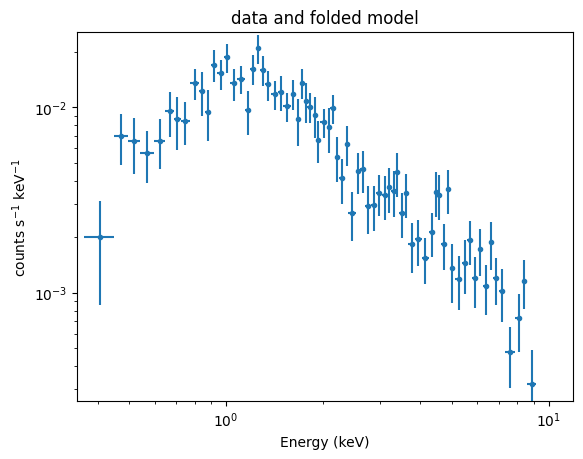

In [30]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.title(labels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')

In [31]:
m = xs.Model("phabs*(gauss + bremss)")


Model phabs<1>(gaussian<2> + bremss<3>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   gaussian   LineE      keV      6.50000      +/-  0.0          
   3    2   gaussian   Sigma      keV      0.100000     +/-  0.0          
   4    2   gaussian   norm                1.00000      +/-  0.0          
   5    3   bremss     kT         keV      7.00000      +/-  0.0          
   6    3   bremss     norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              1.863694e+13     using 72 bins.

Test statistic : Chi-Squared              1.863694e+13     using 72 bins.
 Null hypothesis probability of 0.000000e+00 with 66 degrees of freedom
 Current data and model not fit yet.


In [32]:
xs.Fit.perform()

                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH       2:LineE       3:Sigma        4:norm          5:kT        6:norm
856.824      3.5358e+06   -3      0.391659       6.53197      0.171227   6.05110e-07       195.632   1.13461e-05
409.493      2.59319e+06  -2      0.109068       6.66154      0.304500   5.54521e-07       45.4565   1.70201e-05
278.348      2.96879e+06  -3      0.368603       6.76156      0.518097   1.09931e-06       16.4385   2.50567e-05
222.067      1.76666e+06   0      0.185060       6.66572      0.587940   1.46235e-06       2.97584   3.10873e-05
98.4016      1.77907e+06  -1      0.227125       6.59246      0.940945   2.65974e-06       5.89380   3.07790e-05
67.5768      843206       -2      0.259186       6.60170       1.33461   3.18682e-06       7.27900   3.63656e-05
67.1952      59463.3      -1      0.260485       6.54884       1.52412   3.74659e-06       6.64334   3.66858e-05
67.0185      40588.4      -1      0.263371       6

In [33]:
xs.Fit.renorm()


Fit statistic  : Chi-Squared                   66.71     using 72 bins.

Test statistic : Chi-Squared                   66.71     using 72 bins.
 Null hypothesis probability of 4.52e-01 with 66 degrees of freedom
 Current data and model not fit yet.


In [34]:
xs.Plot("ldata chi")
energies = xs.Plot.x()
edeltas = xs.Plot.xErr()
rates = xs.Plot.y(1,1)
errors = xs.Plot.yErr(1,1)
foldedmodel = xs.Plot.model()
dataLabels = xs.Plot.labels(1)
chiLabels = xs.Plot.labels(2)
# note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
# bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
foldedmodel.append(foldedmodel[-1])
chi = xs.Plot.y(1,2)
chi.append(chi[-1])

***Warning: Fit is not current.


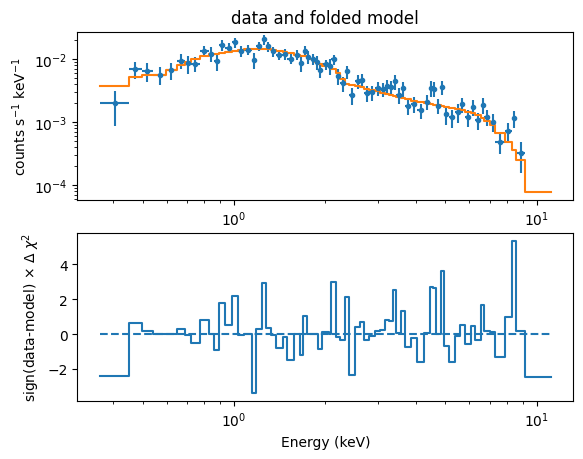

In [35]:
plt.subplot(211)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(dataLabels[1])
plt.title(dataLabels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')
plt.step(stepenergies,foldedmodel,where='post')
plt.subplot(212)
plt.xscale('log')
plt.xlabel(chiLabels[0])
plt.ylabel(chiLabels[1])
plt.step(stepenergies,chi,where='post')
plt.hlines(0.0,stepenergies[0],stepenergies[-1],linestyles='dashed')

In [36]:
xs.Plot("data resid")
energies = xs.Plot.x()
edeltas = xs.Plot.xErr()
rates = xs.Plot.y(1,1)
errors = xs.Plot.yErr(1,1)
foldedmodel = xs.Plot.model()
dataLabels = xs.Plot.labels(1)
residLabels = xs.Plot.labels(2)
# note that for matplotlib step plots we need an x-axis array which includes the start and end value for each
# bin and the y-axis has to be the same size with an extra value added equal to the value of the last bin
nE = len(energies)
stepenergies = list()
for i in range(nE):
    stepenergies.append(energies[i] - edeltas[i])
stepenergies.append(energies[-1]+edeltas[-1])
foldedmodel.append(foldedmodel[-1])
resid = xs.Plot.y(1,2)
residerr = xs.Plot.yErr(1,2)

***Warning: Fit is not current.


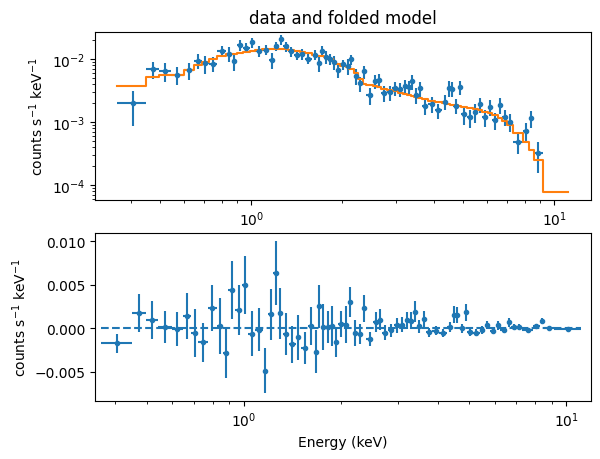

In [37]:
plt.subplot(211)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(dataLabels[1])
plt.title(dataLabels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')
plt.step(stepenergies,foldedmodel,where='post')
plt.subplot(212)
plt.xscale('log')
plt.xlabel(residLabels[0])
plt.ylabel(residLabels[1])
plt.errorbar(energies,resid,xerr=edeltas,yerr=residerr,fmt='.')
plt.hlines(0.0,stepenergies[0],stepenergies[-1],linestyles='dashed')